In [1]:
from vowpalwabbit import pyvw
import random
import matplotlib.pyplot as plt

In [2]:
# !/Library/Developer/CommandLineTools/usr/bin/python3 -m pip install --user seaborn

In [3]:
# VW tries to minimize loss/cost, therefore we will pass cost as -reward
USER_LIKED_ARTICLE = -1.0
USER_DISLIKED_ARTICLE = 0.0

In [4]:
#Define get_cost function
def get_cost(context, action):
    if context['user'] == "Tom":
        if context['time_of_day'] == "morning" and action == "politics":
            return USER_LIKED_ARTICLE
        elif context['time_of_day'] == "afternoon" and action == "music":
            return USER_LIKED_ARTICLE
        else:
            return USER_DISLIKED_ARTICLE
    if context['user'] == "Anna":
        if context['time_of_day'] == "morning" and action == "sports":
            return USER_LIKED_ARTICLE
        elif context['time_of_day'] == "afternoon" and action == "politics":
            return USER_LIKED_ARTICLE
        else:
            return USER_DISLIKED_ARTICLE

In [5]:
#Covert to vw format
def to_vw_example_format(context, actions, cb_label = None):
    if cb_label is not None:
        chosen_action, cost, prob = cb_label
    example_string = ""
    example_string += "shared |User user={} time_of_day={}\n".format(context["user"], context["time_of_day"])
    for action in actions:
        if cb_label is not None and action == chosen_action:
            example_string += "0:{}:{} ".format(cost, prob)
        example_string += "|Action article={} \n".format(action)
    #Strip the last newline
    return example_string[:-1]

In [6]:
context = {"user":"Tom","time_of_day":"morning"}
actions = ["politics", "sports", "music", "food"]

print(to_vw_example_format(context,actions))

shared |User user=Tom time_of_day=morning
|Action article=politics 
|Action article=sports 
|Action article=music 
|Action article=food 


In [7]:
def sample_custom_pmf(pmf):
    total = sum(pmf)
    scale = 1 / total
    pmf = [x * scale for x in pmf]
    draw = random.random()
    sum_prob = 0.0
    for index, prob in enumerate(pmf):
        sum_prob += prob
        if(sum_prob > draw):
            return index, prob

In [8]:
def get_action(vw, context, actions):
    vw_text_example = to_vw_example_format(context,actions)
    pmf = vw.predict(vw_text_example)
    chosen_action_index, prob = sample_custom_pmf(pmf)
    return actions[chosen_action_index], prob

In [9]:
users = ['Tom', 'Anna']
times_of_day = ['morning', 'afternoon']
actions = ["politics", "sports", "music", "food", "finance", "health", "camping"]

def choose_user(users):
    return random.choice(users)

def choose_time_of_day(times_of_day):
    return random.choice(times_of_day)

In [10]:
def run_simulation(vw, num_iterations, users, times_of_day, actions, cost_function, do_learn = True):
    cost_sum = 0.
    ctr = []

    for i in range(1, num_iterations+1):
        # 1. In each simulation choose a user
        user = choose_user(users)
        # 2. Choose time of day for a given user
        time_of_day = choose_time_of_day(times_of_day)

        # 3. Pass context to vw to get an action
        context = {'user': user, 'time_of_day': time_of_day}
        action, prob = get_action(vw, context, actions)

        # 4. Get cost of the action we chose
        cost = get_cost(context, action)
        cost_sum += cost
        
        if do_learn:
            # 5. Inform VW of what happened so we can learn from it
            vw_format = vw.parse(to_vw_example_format(context, actions, (action, cost, prob)),pyvw.vw.lContextualBandit)
            # 6. Learn
            vw.learn(vw_format)
            # 7. Let VW know you're done with these objects
            vw.finish_example(vw_format)

        # We negate this so that on the plot instead of minimizing cost, we are maximizing reward
        ctr.append(-1*cost_sum/i)
    print("Average CTR: ", sum(ctr)/(num_iterations))
    return ctr

In [11]:
def plot_ctr(num_iterations, ctr):
    plt.plot(range(1,num_iterations+1), ctr)
    plt.xlabel('num_iterations', fontsize=14)
    plt.ylabel('ctr', fontsize=14)
    plt.ylim([0,1])

# First Scenario

Average CTR:  0.7399615059556487


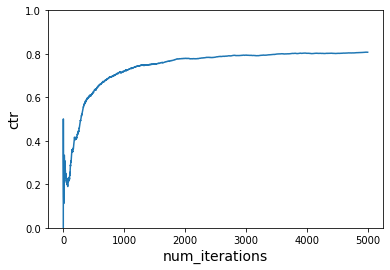

In [12]:
vw = pyvw.vw("--cb_explore_adf -q UA --quiet --epsilon 0.2")

num_iterations = 5000
ctr = run_simulation(vw, num_iterations, users, times_of_day, actions, get_cost)

plot_ctr(num_iterations, ctr)

Average CTR:  0.14041780283268293


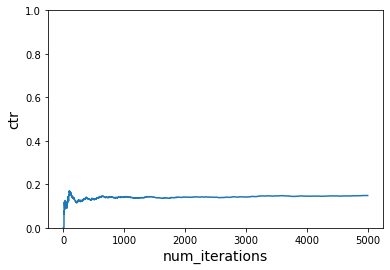

In [13]:
# Instantiate learner in VW
vw = pyvw.vw("--cb_explore_adf -q UA --quiet --epsilon 0.2")

num_iterations = 5000
ctr = run_simulation(vw, num_iterations, users, times_of_day, actions, get_cost, do_learn=False)

plot_ctr(num_iterations, ctr)

# Second Scenario

In [14]:
def get_cost_new1(context,action):
    if context['user'] == "Tom":
        if context['time_of_day'] == "morning" and action == 'politics':
            return USER_LIKED_ARTICLE
        elif context['time_of_day'] == "afternoon" and action == 'sports':
            return USER_LIKED_ARTICLE
        else:
            return USER_DISLIKED_ARTICLE
    elif context['user'] == "Anna":
        if context['time_of_day'] == "morning" and action == 'sports':
            return USER_LIKED_ARTICLE
        elif context['time_of_day'] == "afternoon" and action == 'sports':
            return USER_LIKED_ARTICLE
        else:
            return USER_DISLIKED_ARTICLE

In [15]:
def run_simulation_multiple_cost_functions(vw, num_iterations, users, times_of_day, actions, cost_functions, do_learn = True):
    cost_sum = 0.
    ctr = []

    start_counter = 1
    end_counter = start_counter + num_iterations
    for cost_function in cost_functions:
        for i in range(start_counter, end_counter):
            # 1. in each simulation choose a user
            user = choose_user(users)
            # 2. choose time of day for a given user
            time_of_day = choose_time_of_day(times_of_day)

            # Construct context based on chosen user and time of day
            context = {'user': user, 'time_of_day': time_of_day}

            # 3. Use the get_action function we defined earlier
            action, prob = get_action(vw, context, actions)

            # 4. Get cost of the action we chose
            cost = cost_function(context, action)
            cost_sum += cost

            if do_learn:
                # 5. Inform VW of what happened so we can learn from it
                vw_format = vw.parse(to_vw_example_format(context, actions, (action, cost, prob)),pyvw.vw.lContextualBandit)
                # 6. Learn
                vw.learn(vw_format)

            # We negate this so that on the plot instead of minimizing cost, we are maximizing reward
            ctr.append(-1*cost_sum/i)
        start_counter = end_counter
        end_counter = start_counter + num_iterations
    print("Average CTR: ", sum(ctr)/(num_iterations*len(cost_functions)))
    return ctr

Average CTR:  0.7483832517676693


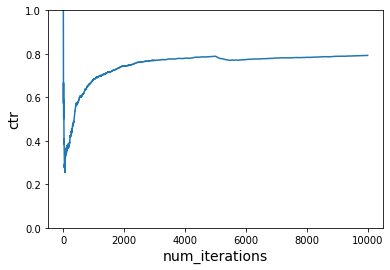

In [16]:
# use first reward function initially and then switch to second reward function

# Instantiate learner in VW
vw = pyvw.vw("--cb_explore_adf -q UA --quiet --epsilon 0.2")

num_iterations_per_cost_func = 5000
cost_functions = [get_cost, get_cost_new1]
total_iterations = num_iterations_per_cost_func * len(cost_functions)

ctr = run_simulation_multiple_cost_functions(vw, num_iterations_per_cost_func, users, times_of_day, actions, cost_functions)

plot_ctr(total_iterations, ctr)

Average CTR:  0.13904221302656106


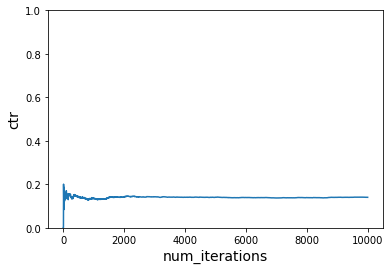

In [17]:
# Do not learn
# use first reward function initially and then switch to second reward function

# Instantiate learner in VW
vw = pyvw.vw("--cb_explore_adf -q UA --quiet --epsilon 0.2")

num_iterations_per_cost_func = 5000
cost_functions = [get_cost, get_cost_new1]
total_iterations = num_iterations_per_cost_func * len(cost_functions)

ctr = run_simulation_multiple_cost_functions(vw, num_iterations_per_cost_func, users, times_of_day, actions, cost_functions, do_learn=False)
plot_ctr(total_iterations, ctr)

# 1. Rewards Incrementer

In [59]:
def run_simulation_with_rewards_incrementer(vw, num_iterations, users, times_of_day, actions, cost_functions, rewards_increment, do_learn = True):
    cost_sum = 0.
    ctr = []
    
    record_info = {"Tom":{"iterations":[], "action":[], "time_of_day":[]}, "Anna":{"iterations":[], "action":[], "time_of_day":[]}}
    
    start_counter = 1
    end_counter = start_counter + num_iterations
    for cost_function in cost_functions:
        current_increment_value = rewards_increment
        for i in range(start_counter, end_counter):
            # 1. in each simulation choose a user
            user = choose_user(users)
            # 2. choose time of day for a given user
            time_of_day = choose_time_of_day(times_of_day)

            # Construct context based on chosen user and time of day
            context = {'user': user, 'time_of_day': time_of_day}

            # 3. Use the get_action function we defined earlier
            action, prob = get_action(vw, context, actions)
            
            #Lets record the context along with the action taken by the model for each iteration
            record_info[context['user']]['iterations'].append(i)
            record_info[context['user']]['action'].append(action)
            record_info[context['user']]['time_of_day'].append(context['time_of_day'])

            # 4. Get cost of the action we chose
            cost = cost_function(context, action)
            # cost = -1 indicates a reward. With every successive reward, the reward value is incremented by the value specified in 'rewards_increment'
            if cost == -1:
                cost = cost+current_increment_value
                cost_sum += cost
                current_increment_value += rewards_increment
            # cost = 0 indicates no reward. If there was a successive run of rewards previously, a 'no rewards' action breaks the streak and sets the 'current_increment_value' back to the original 'rewards_increment' value
            elif cost == 0:
                current_increment_value = rewards_increment

            if do_learn:
                # 5. Inform VW of what happened so we can learn from it
                vw_format = vw.parse(to_vw_example_format(context, actions, (action, cost, prob)),pyvw.vw.lContextualBandit)
                # 6. Learn
                vw.learn(vw_format)

            # We negate this so that on the plot instead of minimizing cost, we are maximizing reward
            ctr.append(-1*cost_sum/i)
        start_counter = end_counter
        end_counter = start_counter + num_iterations
    print("Average CTR: ", sum(ctr)/(num_iterations*len(cost_functions)))
    return ctr, record_info

Average CTR:  0.7435133203119737


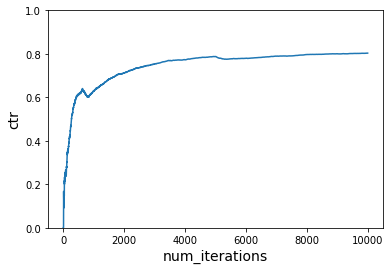

In [61]:
# Instantiate learner in VW
vw = pyvw.vw("--cb_explore_adf -q UA --quiet --epsilon 0.2")

num_iterations_per_cost_func = 5000
rewards_increment = -1e-05
cost_functions = [get_cost, get_cost_new1]
total_iterations = num_iterations_per_cost_func * len(cost_functions)

ctr, record_info = run_simulation_with_rewards_incrementer(vw, num_iterations_per_cost_func, users, times_of_day, actions, cost_functions, rewards_increment)

plot_ctr(total_iterations, ctr)

In [62]:
#Map the time of day to a color for visualization
def color_time_of_day_map(tod):
    if tod == "morning":
        return 0
    elif tod == "afternoon":
        return 1

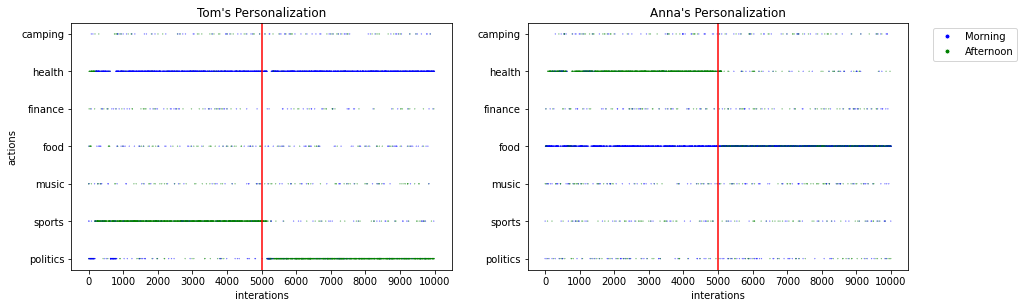

In [63]:
#Side-by-side comparision of Tom's and Anna's Personalization
from matplotlib.colors import ListedColormap
from matplotlib.patches import Patch
from matplotlib.lines import Line2D

plt.figure(figsize=(15,10))
colours = ListedColormap(['b','g'])
classes=["morning", "afternoon"]
legend_elements = [Line2D([0], [0], marker='o', color='w', label='Morning', markerfacecolor='b', markersize=5), Line2D([0], [0], marker='o', color='w', label='Afternoon', markerfacecolor='g', markersize=5)]

plt.subplot(221)
plt.title('Tom\'s Personalization')
plt.xlabel('interations')
plt.ylabel('actions')
plt.xticks(ticks=range(0, total_iterations+1, 1000), labels=range(0, total_iterations+1, 1000))
plt.yticks(ticks=range(len(actions)), labels=actions)
plt.axvline(x=total_iterations/2, color='r')
plt.scatter(record_info['Tom']['iterations'], record_info['Tom']['action'], c=[color_time_of_day_map(day) for day in record_info['Tom']['time_of_day']], cmap=colours, s=.05)

plt.subplot(222)
plt.title('Anna\'s Personalization')
plt.xlabel('interations')
plt.xticks(ticks=range(0, total_iterations+1, 1000), labels=range(0, total_iterations+1, 1000))
plt.yticks(ticks=range(len(actions)), labels=actions)
plt.scatter(record_info['Anna']['iterations'], record_info['Anna']['action'], c=[color_time_of_day_map(day) for day in record_info['Anna']['time_of_day']], cmap=colours, s=.05)
plt.axvline(x=total_iterations/2, color='r')
plt.legend(handles=legend_elements, loc='upper right', bbox_to_anchor=(1.3, 1))
plt.show()

* The red line is a separation between the two cost functions